## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

## Load Data

In [ ]:
try:
    data = pd.read_csv('../data/adj_close.csv', index_col=0, parse_dates=True)
    if isinstance(data.columns, pd.MultiIndex):
        new_cols = []
        for col_tuple in data.columns:
            if 'TSLA' in col_tuple:
                new_cols.append('TSLA')
            elif 'BND' in col_tuple:
                new_cols.append('BND')
            elif 'SPY' in col_tuple:
                new_cols.append('SPY')
            else:
                new_cols.append('_'.join(map(str, col_tuple)).replace('UNNAMED: ', '').replace('_LEVEL_2', ''))
        data.columns = new_cols
        data = data[['TSLA', 'BND', 'SPY']]
    print("Data loaded successfully from adj_close.csv!")
    print("Columns in loaded data:", data.columns)
except Exception as e:
    print(f"Error loading data from adj_close.csv: {e}")
    try:
        raw_data = pd.read_csv('../data/financial_data.csv', header=[0, 1], index_col=0, parse_dates=True)
        data = raw_data['Adj Close']
        data.columns = ['BND', 'SPY', 'TSLA']
        print("Successfully re-extracted 'Adj Close' from 'financial_data.csv'.")
    except Exception as e_fallback:
        print(f"Fallback failed: {e_fallback}. Cannot proceed without proper data.")
        exit()


Data loaded successfully from adj_close.csv!
Columns in loaded data: Index(['('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2')',
       '('CLOSE', 'SPY', 'UNNAMED: 2_LEVEL_2')',
       '('CLOSE', 'TSLA', 'UNNAMED: 3_LEVEL_2')'],
      dtype='object')


## Calculate Daily Returns

In [ ]:
daily_returns = data.pct_change().dropna()
daily_returns.columns = ['BND', 'SPY', 'TSLA']

tsla_predicted_annual_return = -0.54
tsla_expected_daily_return = (1 + tsla_predicted_annual_return)**(1/252) - 1

bnd_expected_daily_return = daily_returns['BND'].mean()
spy_expected_daily_return = daily_returns['SPY'].mean()

bnd_annual_return = bnd_expected_daily_return * 252
spy_annual_return = spy_expected_daily_return * 252

expected_returns = np.array([tsla_predicted_annual_return, bnd_annual_return, spy_annual_return])
assets = ['TSLA', 'BND', 'SPY']

print("\nExpected Annual Returns (for optimization):")
for i, asset in enumerate(assets):
    print(f"{asset}: {expected_returns[i]:.4f}")


Expected Annual Returns (for optimization):
TSLA: -0.5400
BND: 0.0196
SPY: 0.1448


## Covarianc Matrix

In [ ]:
cov_matrix_daily = daily_returns.cov()

cov_matrix_annual = cov_matrix_daily * 252

print("\nAnnualized Covariance Matrix:")
print(cov_matrix_annual)


Annualized Covariance Matrix:
           BND       SPY      TSLA
BND   0.003016  0.001150  0.001861
SPY   0.001150  0.033272  0.052950
TSLA  0.001861  0.052950  0.350331


## Frontier Simulation


Simulated 50000 portfolios.
Sample of portfolio results:
     Return  Volatility  Sharpe_Ratio
0 -0.060552    0.406360     -0.149010
1 -0.208121    0.125522     -1.658046
2  0.055846    0.301577      0.185180
3 -0.170237    0.128635     -1.323413
4  0.032317    0.289269      0.111718


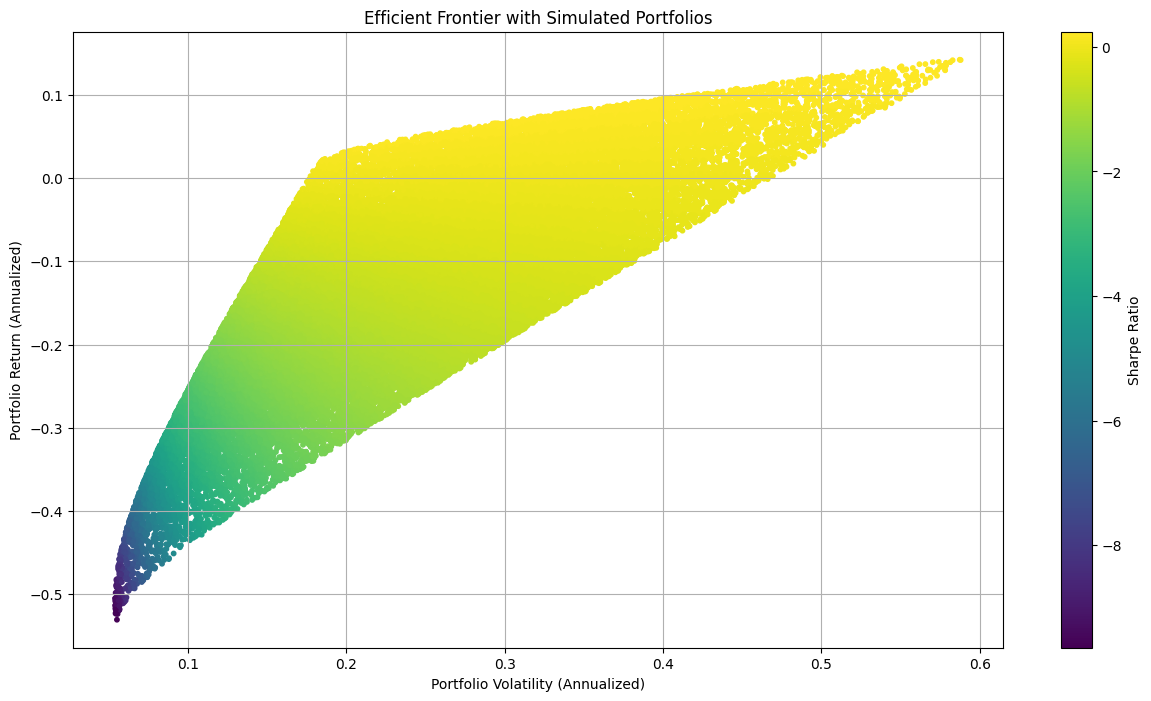

In [ ]:
num_portfolios = 50000
results = np.zeros((3, num_portfolios))
weights_record = []

# Loop to generate random portfolios
for i in range(num_portfolios):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    weights_record.append(weights)

    portfolio_return = np.sum(weights * expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))

    risk_free_rate = 0.0
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = sharpe_ratio

results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe_Ratio'])

print(f"\nSimulated {num_portfolios} portfolios.")
print("Sample of portfolio results:")
print(results_df.head())

plt.figure(figsize=(15, 8))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe_Ratio'], cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier with Simulated Portfolios')
plt.xlabel('Portfolio Volatility (Annualized)')
plt.ylabel('Portfolio Return (Annualized)')
plt.grid(True)
plt.show()

# Identify Key Portfolios


--- Key Portfolios ---

Maximum Sharpe Ratio Portfolio:
Return: 0.1394
Volatility: 0.5704
Sharpe Ratio: 0.2445
Weights:
  TSLA: 0.0000
  BND: 0.0429
  SPY: 0.9571

Minimum Volatility Portfolio:
Return: -0.5053
Volatility: 0.0540
Sharpe Ratio: -9.3586
Weights:
  TSLA: 0.9381
  BND: 0.0619
  SPY: 0.0001


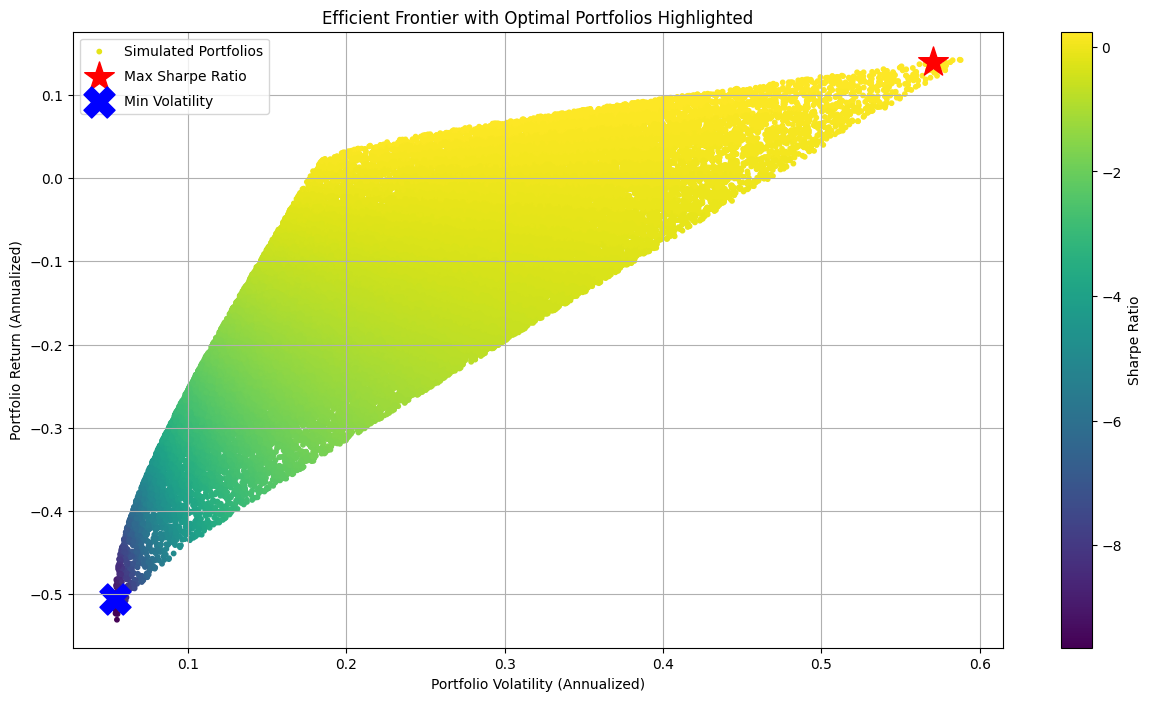

In [ ]:
# Maximum Sharpe Ratio Portfolio
max_sharpe_portfolio = results_df.loc[results_df['Sharpe_Ratio'].idxmax()]
max_sharpe_weights = weights_record[results_df['Sharpe_Ratio'].idxmax()]

# Minimum Volatility Portfolio
min_volatility_portfolio = results_df.loc[results_df['Volatility'].idxmin()]
min_volatility_weights = weights_record[results_df['Volatility'].idxmin()]

print("\n--- Key Portfolios ---")

print("\nMaximum Sharpe Ratio Portfolio:")
print(f"Return: {max_sharpe_portfolio['Return']:.4f}")
print(f"Volatility: {max_sharpe_portfolio['Volatility']:.4f}")
print(f"Sharpe Ratio: {max_sharpe_portfolio['Sharpe_Ratio']:.4f}")
print("Weights:")
for i, asset in enumerate(assets):
    print(f"  {asset}: {max_sharpe_weights[i]:.4f}")

print("\nMinimum Volatility Portfolio:")
print(f"Return: {min_volatility_portfolio['Return']:.4f}")
print(f"Volatility: {min_volatility_portfolio['Volatility']:.4f}")
print(f"Sharpe Ratio: {min_volatility_portfolio['Sharpe_Ratio']:.4f}")
print("Weights:")
for i, asset in enumerate(assets):
    print(f"  {asset}: {min_volatility_weights[i]:.4f}")


# Plot the Efficient Frontier with marked portfolios
plt.figure(figsize=(15, 8))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe_Ratio'], cmap='viridis', s=10, label='Simulated Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier with Optimal Portfolios Highlighted')
plt.xlabel('Portfolio Volatility (Annualized)')
plt.ylabel('Portfolio Return (Annualized)')
plt.grid(True)

# Plot Max Sharpe Ratio Portfolio
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'],
            marker='*', color='red', s=500, label='Max Sharpe Ratio')

# Plot Min Volatility Portfolio
plt.scatter(min_volatility_portfolio['Volatility'], min_volatility_portfolio['Return'],
            marker='X', color='blue', s=500, label='Min Volatility')

plt.legend(labelspacing=0.8)
plt.show()



# Recommend Optimal Portfolio

In [ ]:
print("\n--- Optimal Portfolio Recommendation ---")

recommended_portfolio = max_sharpe_portfolio
recommended_weights = max_sharpe_weights
recommendation_justification = "The Maximum Sharpe Ratio Portfolio is recommended as it provides the highest expected return for each unit of risk taken, making it suitable for investors seeking efficient risk-adjusted growth. It balances potential returns with controlled volatility."

print(f"\nRecommended Portfolio: {recommendation_justification}")
print("\nSummary of Recommended Portfolio (Maximum Sharpe Ratio):")
print(f"Expected Annual Return: {recommended_portfolio['Return']:.4f}")
print(f"Expected Annual Volatility: {recommended_portfolio['Volatility']:.4f}")
print(f"Sharpe Ratio: {recommended_portfolio['Sharpe_Ratio']:.4f}")
print("Optimal Weights:")
for i, asset in enumerate(assets):
    print(f"  {asset}: {recommended_weights[i]:.4f}")




--- Optimal Portfolio Recommendation ---

Recommended Portfolio: The Maximum Sharpe Ratio Portfolio is recommended as it provides the highest expected return for each unit of risk taken, making it suitable for investors seeking efficient risk-adjusted growth. It balances potential returns with controlled volatility.

Summary of Recommended Portfolio (Maximum Sharpe Ratio):
Expected Annual Return: 0.1394
Expected Annual Volatility: 0.5704
Sharpe Ratio: 0.2445
Optimal Weights:
  TSLA: 0.0000
  BND: 0.0429
  SPY: 0.9571
